In [9]:
#main
import csv
from matplotlib import cm
import os
import pandas as pd
import pprint
import pycircos
import sys

import config as cfg
# necesssary to reload changes in config file
import importlib
importlib.reload(cfg)

DBG = False


In [10]:
class DataList:
    def get_file_prefix(self):
        ''' return Partition_Label Sheetname'''
        return self.part_label+'_'+self.sheet

    def __init__(self, dfs, sheet, sheet_matrix ):
        self.sheet = sheet 
        self.parts_skip = []

        # Get the dataframe for this sheet
        #   sort by Partition (row=2) and then Network (row=0)
        #   ex: Blast - Sort by '751 blast' 
        #   must drop Column 0 bc it contains strings and sort can only sort same type
        df = dfs[self.sheet]
        self.part_label = df.iat[2,0]
        df = df.drop(columns=[0])
       
        self.sheet_df = df.sort_values(by=[2,0], axis=1)

        # 0,1,2 are rows to read in as a list, then remove index at col=0 
        self.netw_list = list(self.sheet_df.to_records()[0])[1:] 
        self.nodes_list = list(self.sheet_df.to_records()[1])[1:] 
        self.part_list = list(self.sheet_df.to_records()[2])[1:]   

        #  hold all data
        self.matrix_node_map = self.read_matrix_sheet( sheet_matrix ) 
        self.part_map = self.create_partition_map()

        # add data from matrix sheet 
        self.add_nodes_to_part_map()

        self.map_of_nodes = self.create_map_of_nodes()

        # circos can not handle these conditions
        def create_skip_placeholders():
            self.skip_nodes = []
            for p in self.part_map:
                self.part_map[p].update(warn=[])
                self.part_map[p].update(skip_parts=[])
                self.part_map[p].update(skip_nets=[])
                self.part_map[p].update(skip_nodes=[])
                self.part_map[p].update(dup_nodes=[])
        create_skip_placeholders()
        # Circos ZeroDivisionError on Partitions of length 1
        #   This is because start and end cols of partitions are same for next
        self.validate_data()

        self.create_net_rows()
        self.create_node_rows()

        # create output files used for debugging - put in csv folder
        if cfg.DBG_CREATE_CSV:
            self.create_csv_files()

        self.zero_nodes = [ node for node,ninfo in self.map_of_nodes.items() if 'dest_node' not in ninfo ]

    def create_map_of_nodes(self):
        ''' this is used for looking up ALL node informatio for partition '''
        # nodes: rel_col, abs_col, part, network
        d = {}
        for p in self.part_map:
            node_dict = self.part_map[p]['nodes_start_stop']
            for node in node_dict:
                d[node] = node_dict[node]
 
        # print("MAP NODES",d)
        return d

    def create_partition_map(self):
        ''' This contains all data necessary to draw diagrams'''
        if DBG:
            print('Uniq Partitions:',list(set(self.part_list)))

        part_list = self.part_list
        netw_list = self.netw_list
      
        pdict = self.build_start_stop( part_list,netw_list)

        # get network abs cols and put part in there for printint
        for p in pdict.keys():
            # pdict[p]['partid']=str(p) unnecessary
            pdict[p]['rel_nets'] = self.build_start_stop(pdict[p]['nets'],None )
            # pprint.pp( pdict )
            if pdict[p]['len']==1:
                self.parts_skip.append(p)

        if DBG:
            print("create_partition_map")
            pprint.pp(pdict )

        # add list of nodes to this partition   
        pdict_nodes = self.build_start_stop( part_list,self.nodes_list)
        # add nodes and list of rel_nodes to pdict - reuse build start stop
        for p in pdict.keys():
            pdict[p]['nodes']=pdict_nodes[p]['nets'] # reuse this key
            node_start_stop = self.build_start_stop(pdict_nodes[p]['nets'])
            # print(node_start_stop)
            pdict[p]['nodes_start_stop'] = node_start_stop

        # add Network for each Node into node_start_stop
        for p in pdict.keys():
            nets = pdict[p]['nets']
            nodes = pdict[p]['nodes']
            pdict[p]['nodes_start_stop']
            for ct,node in enumerate(nodes):
                pdict[p]['nodes_start_stop'][node]['netw'] = nets[ct]

                # add absolute col (used for debug info)
                part_col_start = pdict[p]['start']
                node_rel_start = pdict[p]['nodes_start_stop'][node]['start']
                # print(" calc node abs cols and rel col",part_col_start,node_rel_start )
                # ADD 1 to abs col bc cols are zero based 
                pdict[p]['nodes_start_stop'][node]['node_abs_col'] = part_col_start+node_rel_start+1
                pdict[p]['nodes_start_stop'][node]['part'] = p

                # add skip key - don't draw - fill reason in later
                pdict[p]['nodes_start_stop'][node]['skip'] =[]
        
        # add nodes into rel_nets - get nodes for networks
        for p in pdict.keys():
            node_ss = pdict[p]['nodes_start_stop']
            for node in node_ss.keys():
                netw = node_ss[node]['netw']
                if 'nodes' not in pdict[p]['rel_nets'][netw].keys():
                    pdict[p]['rel_nets'][netw]['nodes'] = []
                pdict[p]['rel_nets'][netw]['nodes'].append(node) 

        return pdict

    def read_matrix_sheet(self,matrix_sheet):
        ''' returns dict ofsrc node id: and desc node id.
            dest node id is the COL of the 1st NON-ZERO item'''
        # returns list of columns numbers of first non-zero node
        self.matrix_df = pd.DataFrame(pd.read_excel(cfg.EXCEL_INPUT_FILE,
                sheet_name=matrix_sheet,))
        
        node_dict = {}
   
        # print("TYPE OF REC", type(self.matrix_df.to_records()))
        last_row = None
        for row in self.matrix_df.to_records():
            l = list(row)
            # print(l)
            try:
                node = int(l[1])
                prev_row = l
            except Exception as e:
                print(f"ERROR in matrix_sheet={matrix_sheet}.")
                print(f"There may be an empty row. First 10 columns of bad row:\n{l[:10]}")
                print(f"First 10 columns of last row with good data.\n {prev_row[:10]}\nWARNING message:\n{e}")
                break # stop processing for loop
            # Keep this since holds place for nodes with no non-zero values
            node_dict[node] = { 'node' : node }
            # print("NODE", node, type(node))
      
            for c,val in enumerate(l[2:]): # vals start 2:
                # print(type(val)) # SOME ARE INT64 SOME ARE FLOAT64 
                if val > 0:
                    # print(f"node {node} VALE {val} COL {c}")
                    node_dict[ node ]= {
                        'dest_node' : c+1,
                        'val' : val,
                    }
                    break # go to next ROW
        # print("\n\n MATRIX DICT")
        # pprint.pp( node_dict)
     
        z = [ node for node,ninfo in node_dict.items() if 'dest_node' not in ninfo ]
        print(f"{matrix_sheet} Nodes with 0.0 values: ",z )

        return node_dict

    def add_nodes_to_part_map(self ):
        ''' add dest nodes to this partition '''
  
        for p in self.part_map:
            node_dict = self.part_map[p]['nodes_start_stop']
            for src_node in node_dict:
                dest_node_dict = self.matrix_node_map[src_node]
                if 'dest_node' in dest_node_dict:
                    dest_node = dest_node_dict['dest_node']
                    # print(f"Partition {p} Node {src_node} DestNodeX {dest_node}")
                    self.part_map[p]['nodes_start_stop'][src_node]['dest_node']=dest_node

      
    def validate_data(self):
        ''' circos cannot handle partitions of length one,
            or networks of length one.
            Add skip info all at once - must be run 
                BEFORE building NODE_ROWS '''
        # print("\nvalidate_data()")

        for p in self.part_map:
            # check for partitions of length one
            if self.part_map[p]['len']==1:
                self.part_map[p]['warn'].append( f'Partition:{p} ONLY 1 Network' )
                self.part_map[p]['skip_parts'].append(p)
                # print("SKIP PARTs",self.part_map[p]['skip_parts'])
            
            # check for networks of length one
            for n in self.part_map[p]['rel_nets']: 
                rel_nets = self.part_map[p]['rel_nets']
                nodes = rel_nets[n]['nodes']
                if len(nodes)==1:
                    self.part_map[p]['warn'].append( f'Network:{n} contains ONLY 1 Node:{nodes[0]}' )
                    self.part_map[p]['skip_nets'].append(n)
            
            # Cases not to draw arcs:
            # a) Partition not drawn, only 1 network
            # b) node in matrix sheet has 0.0 values (no NON-ZERO valuess)
            # 
            node_ss = self.part_map[p]['nodes_start_stop']
            for node,node_info in node_ss.items():
                # skip all nodes if partition not drawn
                if p in self.part_map[p]['skip_parts']:
                    self.part_map[p]['warn'].append(  f'Partition:{p} not Drawn, do not Draw its nodes {node}' )
                    self.part_map[p]['skip_nodes'].append(node)

                # node_info = node_ss[node]
                if 'dest_node' not in node_info:
                    self.part_map[p]['warn'].append( f'Node:{node} Matrix Sheet value 0.0' )
                    self.part_map[p]['skip_nodes'].append(node)
                    # node_info['warn'].append(('no_dest_node',node))
                else:
                    dest_node = node_info['dest_node']
                    if dest_node in node_ss:
                        dest_info = node_ss[dest_node]
                        # print("p=",p," node:",node,' nodekey',node_info.keys(),' dest_info',dest_info)
                        if 'dest_node' in dest_info:
                            dest = dest_info['dest_node']
                            if node == dest:
                                node_info['skip'].append(f'src=dest {node},{dest_node}')  
                                self.part_map[p]['warn'].append( f'{node}<->{dest_node}' )
                                # WRONG!! INCORRECTLY SKIPPING NODE if src=dest 
                                # self.part_map[p]['skip_nodes'].append(node)   
                                # print( "node==dest",node,dest)

            self.skip_nodes += self.part_map[p]['skip_nodes']
        self.skip_nodes = sorted(self.skip_nodes) 

    def test_analyze_data(self):
        print(f"\n***{self.get_file_prefix()}")

        print(f"Plot Partitions with 1 Node: {cfg.SHOW_PARTS_WITH_ONE_NODE}")
        print(f"Plot Lines Black: {cfg.BLACK_CHORDS}")

        skip_parts = [] 
        for p in self.part_map.keys():
            for sp in self.part_map[p]['skip_parts']:
                skip_parts.append( sp )
        
        draw_parts = [x for x in list(self.part_map.keys()) if x not in skip_parts]
           
        print(f"{len(self.part_map.keys())} Partitions: {list(self.part_map.keys())}")
        print(f"    {len(skip_parts)} Partitions not Drawn: {skip_parts}")
        print(f"    {len(draw_parts)} Partitions >1 Network: {draw_parts}")
        print(f"    {len(self.skip_nodes)} Nodes not Drawn: {self.skip_nodes}")
        print(f"    Nodes with 0.0 values: {self.zero_nodes}" )
        self.get_part_rows(True)
        self.get_net_rows(True)
        self.get_node_rows(True)
        
        for p in self.part_map.keys():
            self.test_analyze_data_part(p)

    def test_analyze_data_part(self,p):
        ''' print analysis of Partition'''
        part = self.part_map[p]

        skip_nets = sorted(list(set(self.part_map[p]['skip_nets'])))
        nets = list(set(part['nets']))
        draw_nets = [x for x in nets if x not in skip_nets]

        skip_nodes = sorted(list(set(self.part_map[p]['skip_nodes'])))
        nodes = list(set(part['nodes_start_stop'].keys()))
        draw_nodes = [x for x in nodes if x not in skip_nodes]

        print(f"\nPartition: {p}")
        print(f"    Drawn: {self.draw_part(p)}")
        print(f"    {len(nets)} Networks: {nets}")    
        # print(f"        Networks containing 1 Node: {self.get_one_node_list(p)}")
        print(f"        {len(skip_nets)} Networks not Drawn: {skip_nets}")
        print(f"        {len(draw_nets)} Networks >1 Node: {draw_nets}")

        print(f"    {len(part['nodes'])} Nodes: {part['nodes']}")
        print(f"        {len(skip_nodes)} Nodes not Drawn: {skip_nodes}")
        print(f"        {len(draw_nodes)} Nodes     Drawn: {draw_nodes}")

        print(f"\n    Warn List: {part['warn']}")
       

    def test_show_part_info(self,part):
        print("=== All info for Partition: {part}")
        pprint.pp(self.part_map[part])

    #
    # THIS BUILDS DATA USED TO GENERATE DIAGRAMS
    def draw_part(self,p):
        return p not in self.part_map[p]['skip_parts']

    def get_matplot_colors(self,colormap_name,num):
        color_dict = {}
        color_map = cm.get_cmap(colormap_name, num)
        for i in range(color_map.N):
            color_dict[i] = cm.colors.rgb2hex(color_map(i))
        return color_dict

    def get_part_rows(self,label=False):
        ''' str id, length, color '''
        ''''  row = (PART_ID (str), LENGTH(int), COLOR(hex string or name)'''
        # print(f"Partitions: #{len(self.part_map.keys())}")
        # print(f"SHOW_PARTS_WITH_ONE_NODE={cfg.SHOW_PARTS_WITH_ONE_NODE}")
        PARTITION_COLORS = 'rainbow' # matplot color map for testing
        color_dict = self.get_matplot_colors(PARTITION_COLORS,
                        len(self.part_map.keys())+1)
        rows = []
        for p in self.part_map.keys():
            # # only add row if len>1 or draw and len>1
            if self.draw_part(p) or cfg.SHOW_PARTS_WITH_ONE_NODE:
        
                color = color_dict[p] if not cfg.WHITE_PARTS else 'white'
                rows.append( (str(p), # must be string
                              self.part_map[p]['len'], #length
                              color) )
        if label:
            print(f"PARTITION PLOT DATA\nPartition, Length, Color")
            print(rows)
        return rows

    def create_net_rows(self):
        for p in self.part_map.keys():
            self.part_map[p].update(net_row=[])
            # print("Part SKip Nets",p,' skip=',self.part_map[p]['skip_nets'])
            rn = self.part_map[p]['rel_nets']
            for n in rn:
                if n not in self.part_map[p]['skip_nets']:
                    # SUBTRACT 1 from LEN !!! If not bar will extend past partitions
                    new_len = rn[n]['len']-1
                    self.part_map[p]['net_row'].append( (p, rn[n]['start'], #rn[n]['end'],
                                                    new_len, n ))

    def get_net_row_for_part(self,part):
        ''' return network rows for this partition'''
        # part_id, start, width, netw = row
        # if only 1 network then Divide by ZERO ERROR!!!
        return self.part_map[part]['net_row']
                
    def get_net_rows(self,label=False):
        # rows = [self.get_net_row_for_part(part) for part in self.part_map.keys()]
        rows = []
        for part in self.part_map.keys():
            rows = rows + self.get_net_row_for_part(part)
        if label:
            print(f"NETWORK PLOT DATA\nPartition, Network_Start_Col, Length, Network")
            print(rows)
        return rows


    def create_node_rows(self):
        ''' for p,s,sw,d,dw,n,net in rows:
            src = (str(p),s,sw,1000)
            dest = (str(p),d,dw,1000)
            '''
        CIRCLE_DIAM = 1000 # lines go all the way to edge
        # add 'node_rows' into part_map 
        for p in self.part_map.keys():
            self.part_map[p].update(node_rows=[])
            nodes_dict= self.part_map[p]['nodes_start_stop']
            for node,node_info in nodes_dict.items():
                if node not in self.skip_nodes:
                    col = node_info['start']
                    # node_len = node_info['len']
                    # WRONG - NOT NODE LEN THIS IS ONE MORE THAN COL
                    src = (str(p),col,col+cfg.CHORD_WIDTH,CIRCLE_DIAM)

                    if 'dest_node' in node_info: 
                        dest_node = node_info['dest_node']
                        # print(f"Check if DEST NODE in SKIP NODE LIST {dest_node}, {dest_node in self.skip_nodes}")
                        
                        if dest_node not in self.skip_nodes:
                            dest_node_info = self.map_of_nodes[dest_node]

                            desc_col = dest_node_info['start'] 
                            # dest_node_len = dest_node_info['len']
                            dest_p = dest_node_info['part']
                            dest = (str(dest_p),desc_col,desc_col+cfg.CHORD_WIDTH,CIRCLE_DIAM)

                            self.part_map[p]['node_rows'].append( (src,dest,node_info['netw']))

    def get_node_rows(self,label=False):
        # rows = [self.part_map[part]['node_rows'] for part in self.part_map.keys() ]
        rows = []
        for part in self.part_map.keys():
            rows = rows + self.part_map[part]['node_rows']
        if label:
            print(f"{len(rows)} NODE PLOT DATA: Src,Dest (Part,Col,Length,Network,Diameter)")
            print(rows)
        return rows

    def build_start_stop(self,vals,nets=None): 
        d = {}
        ct = 0
        for v in vals:
            if v not in d.keys():
                d[v]={}
                d[v]['start'] = ct
                if nets:
                    d[v]['nets'] = []
            if nets:
                d[v]['nets'].append(nets[ct])
            d[v]['end']=ct 
            d[v]['len']=d[v]['end']-d[v]['start']+1
            ct+=1
        return d   

    #
    # create files useful for debugging
    #
    def create_csv_files(self):
        ''' created csv files, used for debugging '''

        filename = cfg.DBG_CREATE_CSV_FOLDER+self.get_file_prefix()        
        self.sheet_df.to_csv( filename+'_sorted.csv' )

        def writeit(rows,prefix,header):
            cfilename = filename+'_'+prefix+'.csv'
   
            with open(cfilename, 'w') as csvfile: 
                csvwriter = csv.writer(csvfile) 
                csvwriter.writerow(header) 
                csvwriter.writerows(rows)
            # pfile(filename)
        writeit(self.get_part_rows(), 'part',
                ['partition','length','color'])
        writeit(self.get_net_rows(), 'netw',
                ['partition','col','length','network'] )
        writeit(self.get_node_rows(), 'node',
                ['src(partition,col,END_COL,diameter=1000)',
                 'dest(partition,col,END_COL,diameter=1000)',
                 'network'] )


In [11]:

class ReadExcelFile:
    def __init__(self,input_file):
        ''' Generate the csv files for this excel file.
            Notes: 
                1. header=None will read in ALL SPREADSHEETS
                with this setting.
                Matrix Spreadsheet HAS a header so must be read in separately.
                Sorting will Fail if there is a header for subject sheet
                
                2. Nonblast Sheetname has trailing SPACE in name.
        '''
        self.input_file = input_file

        self.dfs = pd.read_excel(
            input_file,
            sheet_name=None, # READS ALL WORSHEETS
            header=None)
        # sheets are in pairs, first is subject, second is matrix
        
        self.sheet_list = list(zip(list(self.dfs.keys())[::2],list(self.dfs.keys())[1::2]))
        print(f"Opened File: {input_file}\n Sheets:{self.sheet_list}")

        self.data_dict = {}

    def process_sheets(self):
        for sub_sheet, matrix_sheet in self.sheet_list:
            self.data_dict[sub_sheet] = DataList( self.dfs, sub_sheet, matrix_sheet)

    def plot_all(self): 
        print("\nCreating Chord Diagrams...")
        for sheet in self.data_dict.keys():
            data_obj = self.data_dict[sheet]

            part_rows = data_obj.get_part_rows()
            net_rows = data_obj.get_net_rows()
            node_rows = data_obj.get_node_rows()

            cir2 = PlotParts(part_rows )
            cir2 = PlotNetworks(net_rows,cir2,cfg.UNH_COLORS)
            PlotChords(node_rows,cir2)
            if cfg.PLOT_TITLE:
                cir2.figure.suptitle(data_obj.get_file_prefix(), fontsize=30,x=1.5)
            if cfg.SAVE_PLOT_IMAGE:
                filename = cfg.SAVE_PLOT_IMAGE_FOLDER+data_obj.get_file_prefix()
                fmt = 'png' # or 'pdf'
                cir2.save(filename,format=fmt,dpi=cfg.PLOT_DPI)
                print(f"Saved Chord Diagram to file: {filename}.{fmt}")
        print(f"\nGenerating {len(self.data_dict)} Images...")

    # helpful for debugging
    def analyze_data(self):
        ''' prints out data analysis '''
        print(f"\n\n{'*'*20}\n***Analyzing Data for Excel File: {self.input_file}")
        print(f"Sheets:{self.sheet_list}")
        for sheet in self.data_dict.keys():
            self.data_dict[sheet].test_analyze_data()    

    def analyze_data_tofile(self):
        ''' save data analysis to a _info.txt'''
        original_stdout = sys.stdout # Save original  
        print(f"\n\n{'*'*20}\n***Analyzing Data for Excel File: {self.input_file}")
        print(f"Sheets:{self.sheet_list}\n")
        for sheet in self.data_dict.keys():
            filename = cfg.DBG_CREATE_CSV_FOLDER +\
                        self.data_dict[sheet].get_file_prefix()+\
                        "_info.txt"

            print(f"Creating {filename}")
            with open(filename, 'w') as f:
                sys.stdout = f
                self.data_dict[sheet].test_analyze_data() 
                sys.stdout = original_stdout # Res
        print("Analyze data complete.")

In [12]:
# THis code is in test_main.ipynb - used for testing too
def PlotParts(rows,interspace=cfg.INTERSPACE):
    '''  partid, length, color_name = row '''
    # plot circle
    circ = pycircos.Gcircle() 
    for row in rows:
        partid,length,color = row
        # if length>1:
        arcc = pycircos.Garc(
                arc_id=partid, 
                size=length, 
                facecolor=color,
                interspace=interspace, 
                raxis_range=(950,1000), 
                labelsize=20,labelposition=60, label_visible=True)
        circ.add_garc(arcc) 
    circ.set_garcs(0,360) # this displays the circle
    return circ  

def PlotNetworks(rows, circ,color_dict ):
    # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
    ''' REQUIRES: 
                part,
                number of networks, 
                network start col within part
                width of network
                network id = color
    '''
    for row in rows:
        part, start, width, netw = row
        try:
            circ.barplot( 
                    str(part), # partition is string!
                    data = [1], # number to draw (only drawing 1 at a time)
                    positions = [start], # col WITHIN PARTITION (NOT CIRCLE COL)
                    width = [width],
                    facecolor = [ color_dict[netw] ],

                    raxis_range=[950,1000], 
                )
        except ZeroDivisionError:
            print(f"ERROR in PlotNetworks() ZeroDivisionError row=",row)
            # print(f"part, start, width, network")
    return circ
    
def PlotNetworksColor(rows, circ ):
    ''' see above for defn. This uses passed in colors'''
    # WARNING!!!! must pass in circ, if store self.circ will NOT DRAW
    for row in rows:
        part, start, width, color = row
        circ.barplot( 
                str(part), # partition is string!
                data = [1], # number to draw (only drawing 1 at a time)
                positions = [start], # col WITHIN PARTITION (NOT CIRCLE COL)
                width = [width],
                facecolor = color,
                raxis_range=[950,1000], 
            )
    return circ

def PlotChords(rows,circ):
    ''' if part is specified, then only plot that partitions chords'''
    # print(f"number of chords: {len(rows)}")
    # pprint.pp(rows) 
    for row in rows:
        src,dest,netw = row
        # print("CHORD src/dest,src,dest)
        color = cfg.UNH_COLORS[netw] if not cfg.BLACK_CHORDS else 'black'
  
        try:
            circ.chord_plot(src, dest, facecolor=color) 
        except ZeroDivisionError:
            print(f"ERROR in PlotChords() ZeroDivisionError {src},{dest},{color} row=\n")
            print(row)
            print(f" Src,Dest (Part,Col,Col+cfg.CHORD_WIDTH,Diameter),network")
        except Exception as e:
            print(f"ERROR in PlotChords() {e}")
            print(f" Src,Dest (Part,Col,Col+cfg.CHORD_WIDTH,Diameter),network")
            print(f"src={src},dest={dest},netw={netw} color={color}")
    return circ

In [13]:
class Test_ReadExcelFile(ReadExcelFile):
    ''' Test functions for '''

    def process_sheets(self,sheet,matrix_sheet):
        ''' just process one sheet '''
        self.sheet = sheet
        print("Test_ReadExcelFile()",self.sheet,matrix_sheet)
        self.data_dict[sheet] = DataList( self.dfs, self.sheet, matrix_sheet)

    def analyze_data_part(self,part):
        print(f"\n\n{'*'*20}\n***Analyze Sheet: {self.sheet} Partition: {part}")
        self.data_dict[self.sheet].test_analyze_data_part(part)

    def print_all_part_info(self,part):
        print(f"\n\n{'*'*20}\n***Partition Info for Sheet: {self.sheet} Partition: {part}")
        pprint.pp(self.data_dict[self.sheet].part_map[part])

    def get_part_rows(self):
        ''' Partition rows sent to plot '''
        return self.data_dict[self.sheet].get_part_rows()
   
    def get_net_rows(self):
        ''' Network rows sent to plot '''
        return self.data_dict[self.sheet].get_net_rows()

    def get_node_rows(self):
        ''' Node rows sent to plot '''
        return self.data_dict[self.sheet].get_node_rows()
        
    def get_net_rows_for_part(self,part):
        ''' return net rows for this sheet and partition'''
        return self.data_dict[self.sheet].get_net_row_for_part(part)

    def plot_all(self):
        ''' plot partial parts, nets or chords '''
        part_rows = self.get_part_rows()
        net_rows = self.get_net_rows()
        node_rows = self.get_node_rows()

        cir2 = PlotParts(part_rows )
        cir2 = PlotNetworks(net_rows,cir2,cfg.UNH_COLORS)
        PlotChords(node_rows,cir2)   
        cir2.figure.suptitle("\n\nTEST "+self.sheet, fontsize=30)
      
    def test_mult(self):
        mult = 10
        
        part_rows = self.get_part_rows()
        net_rows = self.get_net_rows()
        node_rows = self.get_node_rows()

        npart_rows=[(p,l*mult,c) for p,l,c in part_rows]
        nnet_rows=[(p,c,w*mult,n) for p,c,w,n in net_rows]
        nnode_rows=[((s[0],s[1],s[2]*mult,s[3]),(d[0],d[1],d[2]*mult,d[3]),n) for s,d,n in node_rows]

        cir1 = PlotParts(npart_rows)
        cir1 = PlotNetworks(nnet_rows,cir1,cfg.UNH_COLORS)
        PlotChords(nnode_rows,cir1)   
        cir1.figure.suptitle(f"\n\n{self.sheet}\nTest mult*{mult}", fontsize=30)
 

In [14]:
def test_one():
    sheet='Blast'
    matrix_sheet='Blast matrix'
    tobj = Test_ReadExcelFile( cfg.EXCEL_INPUT_FILE)
    tobj.process_sheets(sheet,matrix_sheet )
    tobj.analyze_data()
    tobj.plot_all()
    # tobj.test_mult()
# test_one()

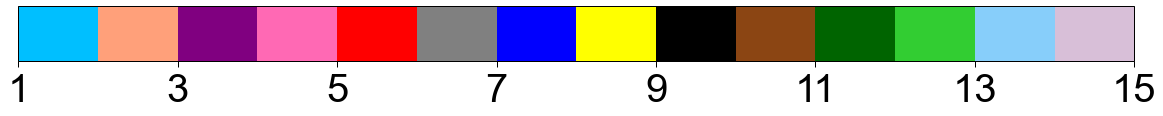

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def show_color_bar(colors,label,tick_labels):
    cmap= mpl.colors.ListedColormap(colors)

    # one more and make ''
    bounds = tick_labels+[ tick_labels[-1]+1]

    # used to draw ticks
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # defines the width of the entire plot - 10 is wider
    fig, ax = plt.subplots(figsize=(20, 1))
    ax.tick_params(labelsize=40)
    
    #  defines the height of the entire plot
    # fig.subplots_adjust(bottom=0.5) # this makes it 1/2 the height
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap,norm=norm),
        cax=ax,
        orientation='horizontal',
        label=label,
    )
    # fig.suptitle('test title', fontsize=20,x=1) # is ontop of color bar
    plt.show()

# https://matplotlib.org/3.5.0/gallery/color/named_colors.html
def plot_colorbar():
    color_names = list(cfg.UNH_COLORS.values())
    color_nums = list( cfg.UNH_COLORS.keys())
    show_color_bar(color_names,'',color_nums)

if cfg.SHOW_COLOR_BAR:
    plot_colorbar()

Opened File: Partitions_Langer.xlsx
 Sheets:[('PWA_reg', 'pwareg matrix'), ('PWA_ran', 'pwaran matrix'), ('Controls', 'Control matrix')]
ERROR in matrix_sheet=pwareg matrix.
There may be an empty row. First 10 columns of bad row:
[264, nan, nan, nan, nan, nan, nan, nan, nan, nan]
First 10 columns of last row with good data.
 [263, 264.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
WARNING message:
cannot convert float NaN to integer
pwareg matrix Nodes with 0.0 values:  [7, 12, 16, 38, 74, 75, 95, 96, 97, 98, 114, 119, 120, 123, 131, 134, 149, 158, 159, 168, 190, 196, 200, 205, 206, 208, 216, 218, 220, 223]
pwaran matrix Nodes with 0.0 values:  [41, 45, 46, 78, 104, 107, 109, 123, 125, 157, 161, 163, 186, 196, 205, 208, 209, 210, 213, 230, 232, 251, 262, 264]
Control matrix Nodes with 0.0 values:  [5, 8, 10, 26, 28, 63, 68, 70, 95, 106, 117, 120, 121, 123, 126, 145, 147, 168, 180, 182, 200, 204, 205, 240]


********************
***Analyzing Data for Excel File: Partitions_Langer.xlsx
Sheet

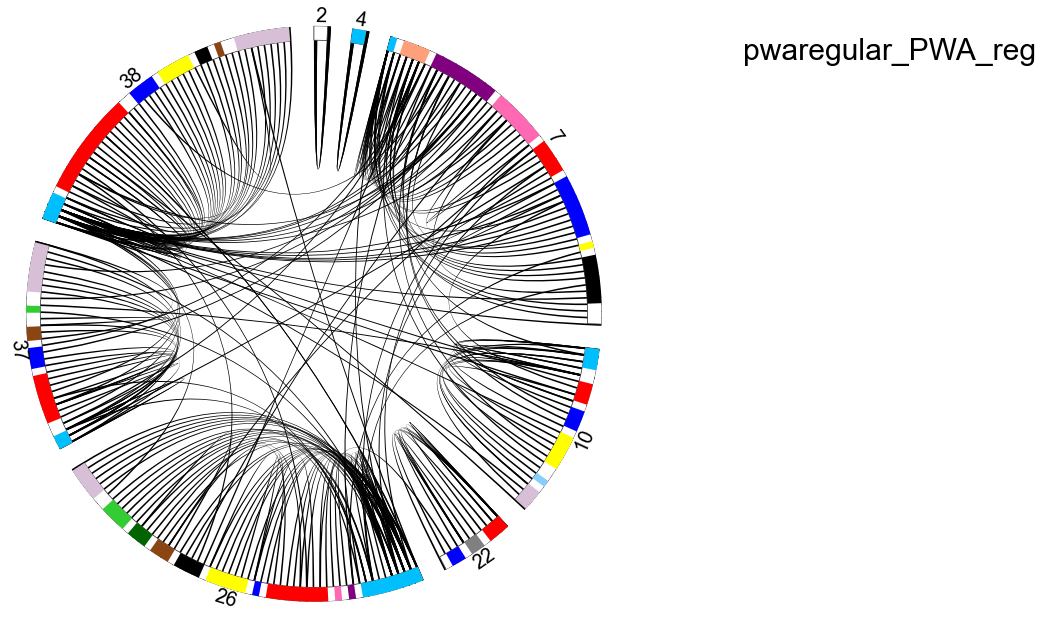

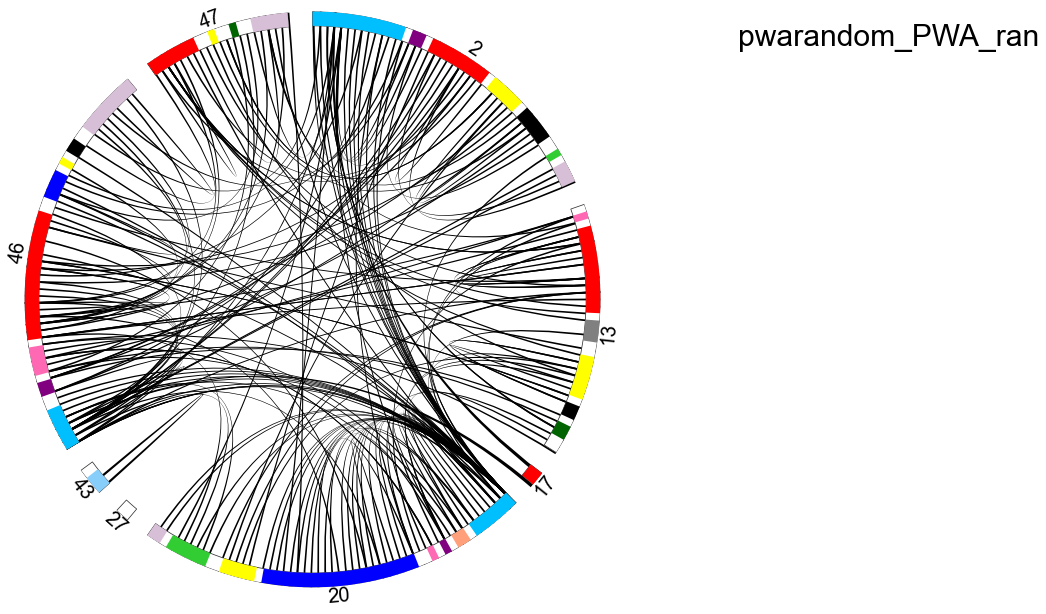

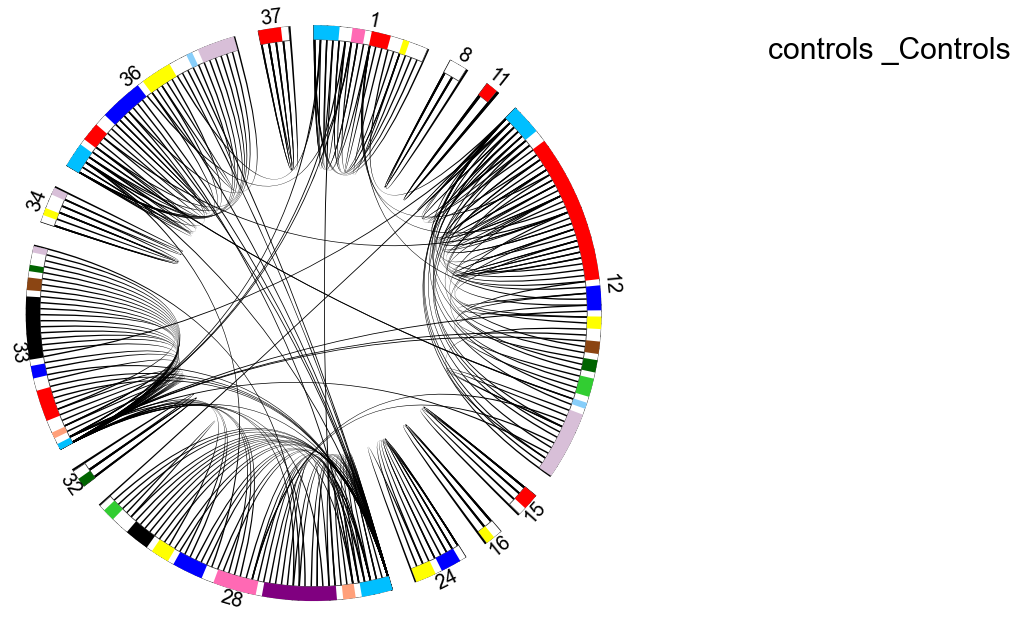

In [16]:
def official_run():
    # import config as cfg
    # import importlib
    # importlib.reload(cfg)

    obj = ReadExcelFile( cfg.EXCEL_INPUT_FILE )
    obj.process_sheets()
    # obj.analyze_data() # writes to stdout
    obj.analyze_data_tofile() # writes to files
    obj.plot_all()

official_run()